# **Violencia machista en Colombia: Un análisis georreferenciado mediante minería de textos y webscraping**

Alumna: Erika Viviana Riaño Bejar

Directora: Sofía Huerta


En este trabajo se llevan a cabo análisis exploratorios de artículos periodísticos sobre violencia machista en Colombia, extraídos de diversos medios digitales mediante técnicas de web scraping y procesados con métodos de minería de textos y procesamiento de lenguaje natural. El estudio abarca publicaciones comprendidas entre 2016 y el 30 de junio de 2025, con especial énfasis en los análisis de georreferenciación que permiten identificar la distribución espacial de los hechos reportados.

# **Importación de librerías y módulos**

In [11]:
cd /content/TFM

/content/TFM


In [50]:
import os
import shutil
import hashlib
from collections import defaultdict
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np
import itertools
import warnings
import folium
import geopandas as gpd
import unicodedata
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut, GeocoderServiceError
import time

# **Revision y Eliminación de Articulos Duplicados**

El script valida si existen artículos con el mismo identificador y contenido; en caso de encontrar duplicados, conserva una copia y mueve las demás a una carpeta denominada duplicados.




In [6]:
def get_base_name(filename):
    """Extrae el nombre base antes del último guion bajo (antes del número final)."""
    name = os.path.splitext(filename)[0]  # Quita la extensión
    parts = name.rsplit('_', 1)  # Divide desde el último _
    return parts[0] if len(parts) == 2 else name

def compute_file_hash(filepath):
    """Calcula un hash del contenido del archivo para comparar si son iguales."""
    hash_sha256 = hashlib.sha256()
    with open(filepath, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_sha256.update(chunk)
    return hash_sha256.hexdigest()

def move_duplicates_to_folder(directory):
    # Ruta de la carpeta de duplicados
    duplicates_folder = os.path.join(directory, "duplicados")
    os.makedirs(duplicates_folder, exist_ok=True)

    # Obtener todos los archivos CSV
    csv_files = [f for f in os.listdir(directory) if f.endswith('.csv')]

    if not csv_files:
        print("No se encontraron archivos CSV en el directorio.")
        return

    # Agrupar por nombre base
    grouped_files = defaultdict(list)
    for filename in csv_files:
        base_name = get_base_name(filename)
        grouped_files[base_name].append(filename)

    moved_files = []

    for base_name, file_list in grouped_files.items():
        if len(file_list) < 2:
            continue  # No hay duplicados potenciales

        # Calcular hash del contenido para cada archivo
        file_with_hash = []
        for filename in file_list:
            filepath = os.path.join(directory, filename)
            if os.path.exists(filepath):  # Verifica que exista
                file_hash = compute_file_hash(filepath)
                file_with_hash.append((filename, file_hash))

        # Agrupar por contenido (hash)
        content_groups = defaultdict(list)
        for filename, file_hash in file_with_hash:
            content_groups[file_hash].append(filename)

        # Procesar cada grupo de contenido idéntico
        for file_group in content_groups.values():
            if len(file_group) > 1:
                # Dejar el primero en la carpeta raíz, mover los demás
                keep = file_group[0]
                duplicates = file_group[1:]

                for duplicate in duplicates:
                    src = os.path.join(directory, duplicate)
                    dst = os.path.join(duplicates_folder, duplicate)

                    try:
                        shutil.move(src, dst)
                        moved_files.append(duplicate)
                        print(f"Movido: {duplicate} → duplicados/")
                    except Exception as e:
                        print(f"Error moviendo {duplicate}: {e}")

    print("\nResumen:")
    print(f"Archivos movidos a 'duplicados/': {len(moved_files)}")
    if moved_files:
        for f in moved_files:
            print(f"  - {f}")
    else:
        print("No se encontraron duplicados para mover.")

# --- Ejecución ---
if __name__ == "__main__":
    directory = "/content/TFM/articulos_x_procesar_ElTiempo_Duplicados"  # ⚠️ Cambia esto por tu ruta real
    move_duplicates_to_folder(directory)

Movido: ElTiempo_20180523163721_8.csv → duplicados/
Movido: ElTiempo_20180615145748_12.csv → duplicados/
Movido: ElTiempo_20180727072318_36.csv → duplicados/
Movido: ElTiempo_20180307220021_3.csv → duplicados/
Movido: ElTiempo_20180307220021_20.csv → duplicados/
Movido: ElTiempo_20180625110527_15.csv → duplicados/
Movido: ElTiempo_20180625110527_31.csv → duplicados/
Movido: ElTiempo_20170524223154_9.csv → duplicados/
Movido: ElTiempo_20180722120636_35.csv → duplicados/
Movido: ElTiempo_20180228204945_18.csv → duplicados/
Movido: ElTiempo_20170523210952_5.csv → duplicados/
Movido: ElTiempo_20180128231913_17.csv → duplicados/
Movido: ElTiempo_20180529143714_9.csv → duplicados/
Movido: ElTiempo_20180604173854_28.csv → duplicados/
Movido: ElTiempo_20180115102139_16.csv → duplicados/
Movido: ElTiempo_20170415153315_3.csv → duplicados/
Movido: ElTiempo_20180716213837_17.csv → duplicados/
Movido: ElTiempo_20170604182925_8.csv → duplicados/
Movido: ElTiempo_20180531203457_27.csv → duplicados/


# **Lectura del archivo JSON**




El archivo en formato JSON se encuentra disponible en el repositorio público de GitHub https://github.com/erikarbj/Violencia-machista-en-Colombia-Analisis-georreferenciado-mineria-de-textos-y-webscraping y corresponde al resultado del análisis realizado mediante técnicas de procesamiento de lenguaje natural sobre los artículos.

In [7]:
# --- 1. URL del archivo JSON en GitHub (usa el enlace "Raw") ---
url = "https://raw.githubusercontent.com/erikarbj/Violencia-machista-en-Colombia-Analisis-georreferenciado-mineria-de-textos-y-webscraping/main/noticias_estandarizadas_Tiempo_24082025.json"

# --- 2. Descargar el contenido ---
response = requests.get(url)
response.raise_for_status()  # Lanza error si la descarga falla

# --- 3. Cargar en un DataFrame ---
data = response.json()
df = pd.DataFrame(data)

# --- 4. Mostrar las 5 primeras filas ---
print(df.head())


                      ID_noticia       fecha  \
0  COL_ElTiempo_20160212094107_0  12/02/2016   
1  COL_ElTiempo_20160212094107_1  12/02/2016   
2  COL_ElTiempo_20160314214129_2  14/03/2016   
3  COL_ElTiempo_20160319061311_2  19/03/2016   
4  COL_ElTiempo_20170402074337_3  02/04/2017   

                                               token    diario      país  \
0  {'abuso sexual': 0, 'pretensiones sexuales': 0...  eltiempo  Colombia   
1  {'abuso sexual': 0, 'pretensiones sexuales': 0...  eltiempo  Colombia   
2  {'abuso sexual': 0, 'pretensiones sexuales': 0...  eltiempo  Colombia   
3  {'abuso sexual': 0, 'pretensiones sexuales': 0...  eltiempo  Colombia   
4  {'abuso sexual': 0, 'pretensiones sexuales': 0...  eltiempo  Colombia   

                      ubicacion_noticia  \
0  Colombia (ubicación no especificada)   
1  Colombia (ubicación no especificada)   
2  Colombia (ubicación no especificada)   
3   Putumayo, Sin especificar municipio   
4                        Bogotá, Bogotá


# **Análisis exploratorio de información**



---





## **Distribución temporal de los eventos de violencia machista**`




✅ Filtrado: 1367 noticias de Colombia


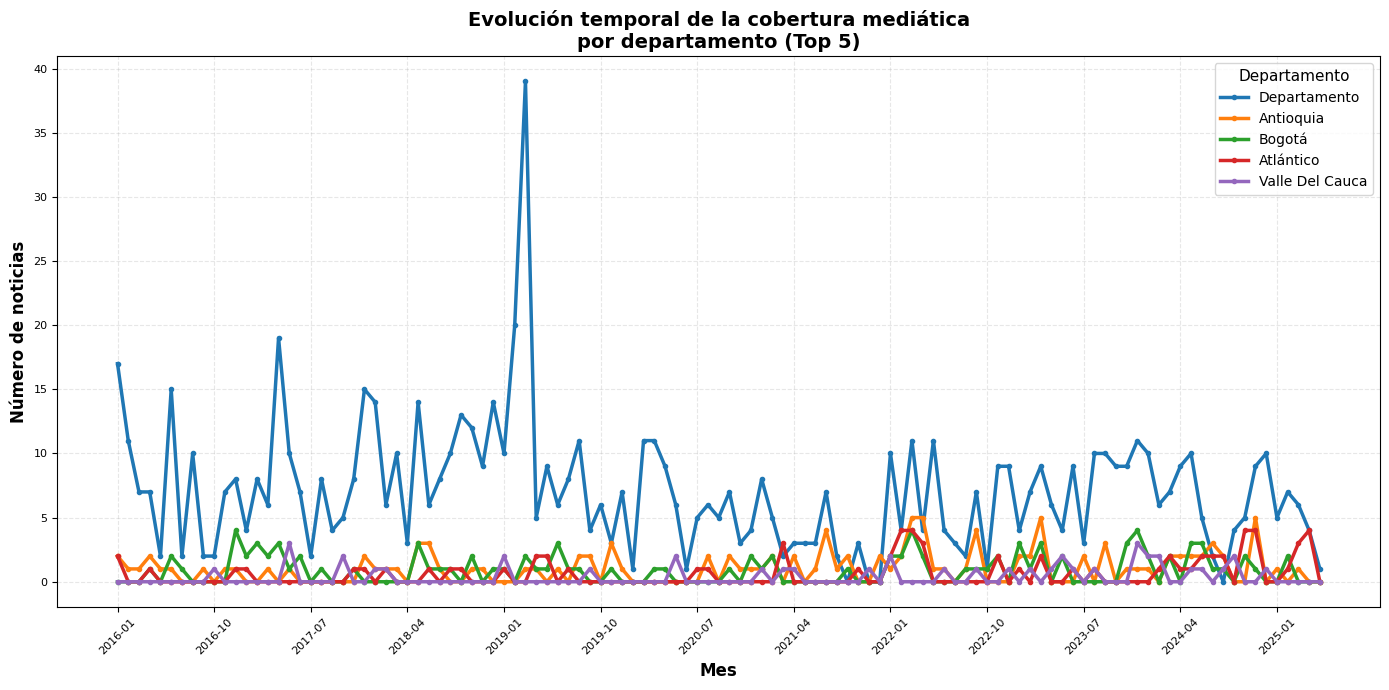

✅ Datos procesados guardados en 'resultados/'


In [51]:
# --- 1. Leer el archivo Excel ---
archivo = '/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal2.xlsx'
df = pd.read_excel(archivo)

# Corregir codificación de columnas
df.columns = [col.replace('paÃ­s', 'pais') if 'paÃ­s' in col else col for col in df.columns]

# Verificar columna 'país'
if 'pais' not in df.columns:
    raise ValueError("No se encontró la columna 'pais' en el archivo.")

# --- 2. Filtrar noticias de Colombia ---
df['pais'] = df['pais'].astype(str).str.strip().str.lower()
colombia = df[df['pais'] == 'colombia'].copy()

if len(colombia) == 0:
    print("⚠️ No se encontraron noticias de Colombia.")
    print("Valores únicos en 'país':", df['pais'].value_counts().index.tolist())
    exit()

print(f"✅ Filtrado: {len(colombia)} noticias de Colombia")

# --- 3. Extraer departamento de 'Departamento' ---
if 'Departamento' not in colombia.columns:
    raise ValueError("No se encontró la columna 'Departamento'.")

# Extraer el departamento (primer parte antes de la coma)
colombia['departamento'] = (
    colombia['Departamento']
    .astype(str)
    .str.split(',')
    .str[0]
    .str.strip()
    .str.title()
)

# Eliminar valores no válidos
colombia = colombia[
    (colombia['departamento'] != 'Sin Especificar Departamento') &
    (colombia['departamento'] != 'Sin especificar departamento') &
    (colombia['departamento'] != 'None') &
    (colombia['departamento'] != '')
]

# --- 4. Procesar fecha y crear serie temporal ---
if 'fecha' not in colombia.columns:
    raise ValueError("No se encontró la columna 'fecha'.")

colombia['fecha'] = pd.to_datetime(colombia['fecha'], errors='coerce')
colombia = colombia.dropna(subset=['fecha'])
colombia['año'] = colombia['fecha'].dt.year
colombia['mes'] = colombia['fecha'].dt.to_period('M')

# Filtrar rango temporal real (2016–2025)
colombia = colombia[(colombia['año'] >= 2016) & (colombia['año'] <= 2025)]

# --- 5. Gráfico espacio-temporal: Heatmap por departamento y mes ---
# Contar noticias por mes y departamento
timeline_geo = colombia.groupby(['mes', 'departamento']).size().unstack(fill_value=0)

# Seleccionar top 15 departamentos por frecuencia
top_15_dptos = timeline_geo.sum().nlargest(15).index
timeline_top = timeline_geo[top_15_dptos]


# --- 6. Serie temporal con top 5 departamentos ---
top_5_dptos = timeline_geo.sum().nlargest(5).index

plt.figure(figsize=(14, 7))
for dpto in top_5_dptos:
    if dpto in timeline_geo.columns:
        data = timeline_geo[dpto].reindex(timeline_geo.index).fillna(0)
        plt.plot(data.index.astype(str), data.values, label=dpto, linewidth=2.5, marker='o', markersize=3)

plt.title('Evolución temporal de la cobertura mediática\npor departamento (Top 5)', fontsize=14)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Número de noticias', fontsize=12)
plt.xticks(rotation=45)

# Ajustar las etiquetas del eje X para mostrar solo algunas fechas
n = len(timeline_geo.index)
# Mostrar aproximadamente 12 etiquetas como máximo (una por mes si es anual)
step = max(1, n // 12)  # Asegurar que step sea al menos 1
plt.gca().set_xticks(plt.gca().get_xticks()[::step])
plt.gca().set_xticklabels([str(label) for label in timeline_geo.index.astype(str)[::step]])

plt.legend(title='Departamento', fontsize=10, title_fontsize=11)
plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('resultados/serie_temporal_top5.png', dpi=300, bbox_inches='tight')
plt.show()

# --- 8. Guardar datos procesados ---
colombia.to_excel('resultados/noticias_colombia_procesadas.xlsx', index=False)
print("✅ Datos procesados guardados en 'resultados/'")

## **Cobertura mediática por departamentos**

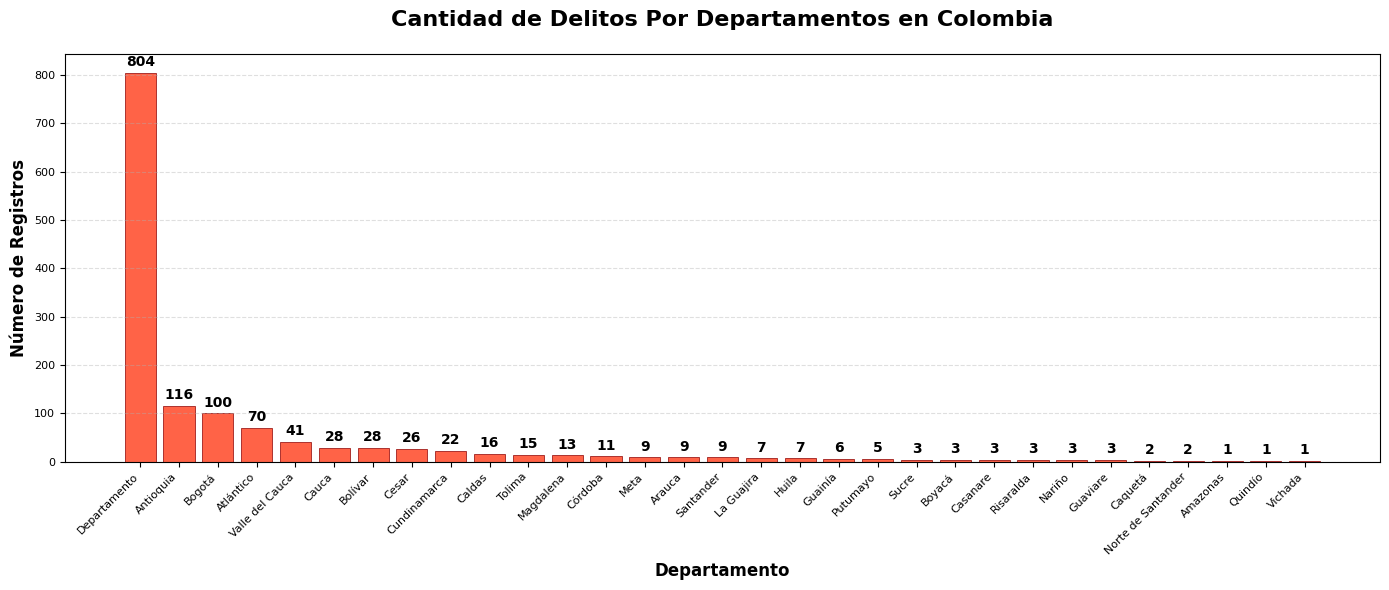

In [52]:
# --- 1. Leer archivo ---
archivo = "/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal2.xlsx"
df = pd.read_excel(archivo)

# --- 2. Filtrar solo registros de Colombia ---
df = df[df["pais"] == "Colombia"]

# --- 3. Extraer departamento (asumiendo que 'Departamento' es el campo correcto) ---
# Nota: estás usando "Departamento", no "ubicacion_noticia", así que lo corregimos
df["departamento"] = df["Departamento"].astype(str).str.split(",").str[0].str.strip()

# Filtrar valores inválidos
df = df[df["departamento"] != "nan"]
df = df[df["departamento"] != ""]

# --- 4. Contar los delitos (columna H) por departamento ---
# Nota: columna H -> índice 7
columna_delito = df.columns[7]  # Esta es la primera columna de delitos (ej: 'abuso sexual')
conteo = df.groupby("departamento")[columna_delito].count().sort_values(ascending=False)

# --- 5. Seleccionar los 40 departamentos con más delitos ---
top10 = conteo.head(40)

# --- 6. Graficar con valores encima de las barras ---
plt.figure(figsize=(14, 6))
bars = plt.bar(top10.index, top10.values, color="tomato", edgecolor='darkred', linewidth=0.5)

# Añadir valor encima de cada barra
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2.,  # Posición X: centro de la barra
        height + max(top10.values) * 0.01,   # Posición Y: un poco encima
        f'{int(height)}',                    # Texto: valor entero
        ha='center',                         # Alineación horizontal
        va='bottom',                         # Alineación vertical
        fontsize=10,
        fontweight='bold'
    )

# --- 7. Personalizar gráfica ---
plt.title("Cantidad de Delitos Por Departamentos en Colombia", fontsize=16, fontweight='bold', pad=20)
plt.ylabel("Número de Registros", fontsize=12)
plt.xlabel("Departamento", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.4, zorder=0)
plt.tight_layout()

# --- 8. Guardar y mostrar ---
plt.savefig("top10_departamentos_colombia.png", dpi=300, bbox_inches='tight')
plt.show()

## **Distribución de palabras de violencia machista en Colombia**

In [53]:

# --- 1. Configuración ---
archivo = "/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal2.xlsx"

# --- 2. Leer el archivo Excel ---
df = pd.read_excel(archivo)

# --- 3. Verificar columnas ---
delitos_cols = df.columns[7:].tolist()  # Todas las columnas desde H en adelante
if 'Departamento' not in df.columns:
    raise ValueError("No se encuentra la columna 'Departamento' en el archivo.")
if 'pais' not in df.columns:
    raise ValueError("No se encuentra la columna 'pais' en el archivo.")

# --- 4. Filtrar solo Colombia ---
df['Departamento'] = df['Departamento'].astype(str).str.strip()
df = df[df['Departamento'].notna()]
df = df[df['Departamento'] != '']
df = df[df['Departamento'] != '0']
df = df[df['pais'].str.strip().str.lower() == "colombia"]

# --- 5. Convertir delitos a numérico ---
df[delitos_cols] = df[delitos_cols].apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# --- 6. Sumar todos los delitos a nivel Colombia ---
colombia_totales = df[delitos_cols].sum()

# --- 7. Crear carpeta de salida ---
os.makedirs("analisis_nacional", exist_ok=True)

# --- 8. Colores ---
colors = plt.cm.tab20.colors
if len(delitos_cols) > len(colors):
    colors = list(itertools.islice(itertools.cycle(colors), len(delitos_cols)))

# --- 9. Generar gráfica nacional ---
plt.figure(figsize=(14, 7))

ax = colombia_totales.plot(
    kind="bar",
    color=colors[:len(delitos_cols)],
    edgecolor="black",
    linewidth=0.7
)

# --- 10. Agregar valores encima de cada barra ---
for i, v in enumerate(colombia_totales):
    ax.text(
        i, v + 0.5, f"{v:,}",   # con separador de miles
        ha="center", va="bottom",
        fontsize=8, rotation=0
    )

# --- 11. Personalización ---
plt.title("Distribución de Delitos en Colombia", fontsize=18, fontweight="bold")
plt.ylabel("Cantidad de Noticias Reportadas", fontsize=12)
plt.xlabel("Tipos de Delitos", fontsize=12)
plt.xticks(rotation=75, ha="right", fontsize=9)
plt.grid(axis="y", linestyle="--", alpha=0.6)

plt.tight_layout()

# --- 12. Guardar ---
ruta_png = "analisis_nacional/delitos_colombia.png"
ruta_pdf = "analisis_nacional/delitos_colombia.pdf"

plt.savefig(ruta_png, dpi=300, bbox_inches="tight")
plt.savefig(ruta_pdf, format="pdf", bbox_inches="tight")
plt.close()

print(f"✅ Gráficas guardadas:")
print(f"   PNG: {ruta_png}")
print(f"   PDF: {ruta_pdf}")

✅ Gráficas guardadas:
   PNG: analisis_nacional/delitos_colombia.png
   PDF: analisis_nacional/delitos_colombia.pdf


## **Distribución de palabras por categorías**

✅ Filtrado: 1367 noticias de Colombia


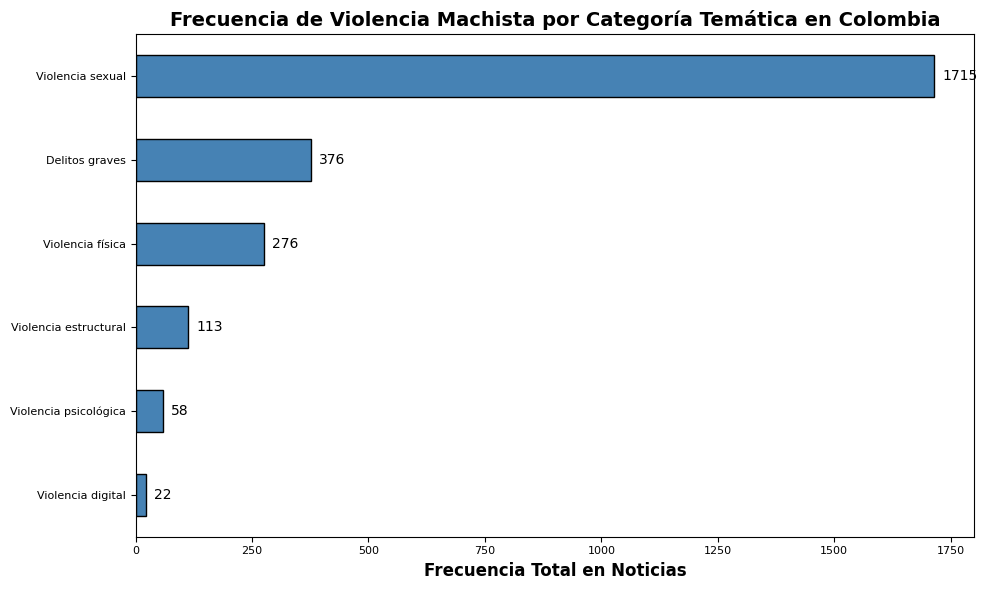

In [54]:

# --- 1. Leer el archivo Excel ---
archivo = '/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal2.xlsx'
try:
    df = pd.read_excel(archivo)
except FileNotFoundError:
    print(f"❌ No se encontró el archivo: {archivo}")
    exit()

# Corregir posible error de codificación en el nombre de la columna
df.columns = [col.replace('paÃ­s', 'pais') if 'paÃ­s' in col else col for col in df.columns]

# Verificar que existe la columna 'país'
if 'pais' not in df.columns:
    print("❌ No se encontró la columna 'país'. Revisa el archivo.")
    print("Columnas disponibles:", df.columns.tolist())
    exit()

# --- 2. Filtrar solo noticias de Colombia ---
df['pais'] = df['pais'].astype(str).str.strip().str.lower()
colombia = df[df['pais'] == 'colombia'].copy()

if len(colombia) == 0:
    print("⚠️ No se encontraron noticias de Colombia. Valores únicos en 'país':")
    print(df['pais'].value_counts())
    exit()

print(f"✅ Filtrado: {len(colombia)} noticias de Colombia")

# --- 3. Identificar columnas de violencia (desde la columna H en adelante) ---
start_idx = 7  # Columna H
violence_columns = df.columns[start_idx:].tolist()

colombia_violencia = colombia[violence_columns].copy()
colombia_violencia = colombia_violencia.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Sumar la frecuencia total de cada delito
frecuencia = colombia_violencia.sum().sort_values(ascending=False)

# --- 8. Categorías temáticas ---
categorias = {
    'Violencia física': ['violencia fisica', 'agresion sexual', 'violencia domestica', 'violencia familiar', 'violencia intrafamiliar'],
    'Violencia sexual': ['abuso sexual', 'violacion', 'violaciones', 'acceso carnal violento', 'acto sexual violento'],
    'Violencia digital': ['ciberviolencia', 'ciberacoso', 'ciberhostigamiento', 'doxing', 'revenge porn'],
    'Violencia estructural': ['discriminacion femenina', 'machismo', 'techo de cristal', 'sexismo', 'cultura de violacion'],
    'Delitos graves': ['feminicidio', 'asesinatos de mujeres', 'trata de mujeres', 'matrimonio forzado', 'esclavitud sexual'],
    'Violencia psicológica': ['violencia psicologica', 'violencia emocional', 'misoginia', 'microagresiones']
}

suma_categorias = {}
for cat, cols in categorias.items():
    existentes = [c for c in cols if c in colombia_violencia.columns]
    suma_categorias[cat] = colombia_violencia[existentes].sum(axis=1).sum()

# Gráfico de barras horizontal por categoría
plt.figure(figsize=(10, 6))
serie_categorias = pd.Series(suma_categorias).sort_values()
bars = serie_categorias.plot(kind='barh', color='steelblue', edgecolor='black')
plt.title('Frecuencia de Violencia Machista por Categoría Temática en Colombia', fontsize=14, fontweight='bold')
plt.xlabel('Frecuencia Total en Noticias', fontsize=12)

for i, v in enumerate(serie_categorias):
    plt.text(v + max(suma_categorias.values()) * 0.01, i, str(v), color='black', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## **Distribución de Categorias de Violencia Machista en Colombia**

✅ Filtrado: 1367 noticias de Colombia


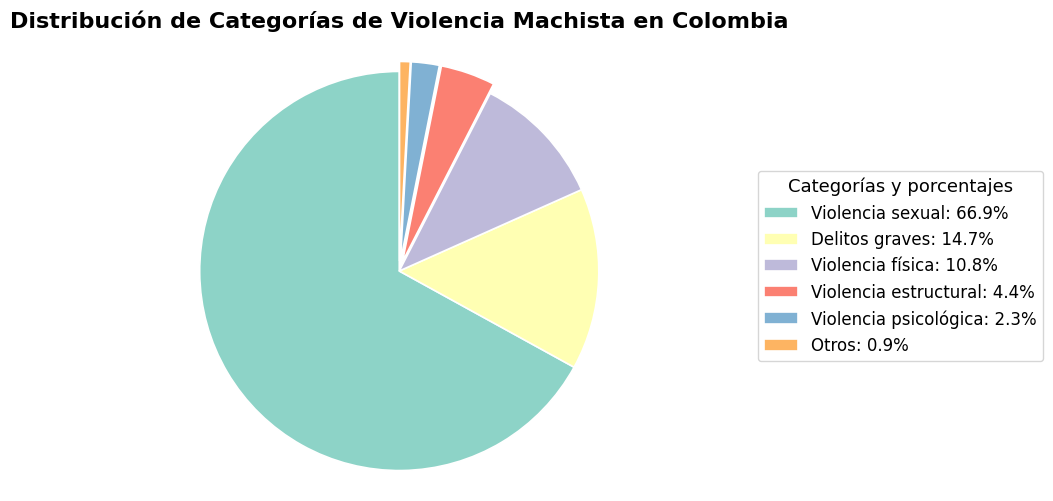

In [55]:
# --- 1. Leer el archivo Excel ---
archivo = '/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal2.xlsx'
try:
    df = pd.read_excel(archivo)
except FileNotFoundError:
    print(f"❌ No se encontró el archivo: {archivo}")
    exit()

# Corregir posible error de codificación en el nombre de la columna
df.columns = [col.replace('paÃ­s', 'pais') if 'paÃ­s' in col else col for col in df.columns]

# Verificar que existe la columna 'país'
if 'pais' not in df.columns:
    print("❌ No se encontró la columna 'país'. Revisa el archivo.")
    print("Columnas disponibles:", df.columns.tolist())
    exit()

# --- 2. Filtrar solo noticias de Colombia ---
df['pais'] = df['pais'].astype(str).str.strip().str.lower()
colombia = df[df['pais'] == 'colombia'].copy()

if len(colombia) == 0:
    print("⚠️ No se encontraron noticias de Colombia. Valores únicos en 'país':")
    print(df['pais'].value_counts())
    exit()

print(f"✅ Filtrado: {len(colombia)} noticias de Colombia")


# --- 8. Categorías temáticas ---
categorias = {
    'Violencia física': ['violencia fisica', 'agresion sexual', 'violencia domestica', 'violencia familiar', 'violencia intrafamiliar'],
    'Violencia sexual': ['abuso sexual', 'violacion', 'violaciones', 'acceso carnal violento', 'acto sexual violento'],
    'Violencia digital': ['ciberviolencia', 'ciberacoso', 'ciberhostigamiento', 'doxing', 'revenge porn'],
    'Violencia estructural': ['discriminacion femenina', 'machismo', 'techo de cristal', 'sexismo', 'cultura de violacion'],
    'Delitos graves': ['feminicidio', 'asesinatos de mujeres', 'trata de mujeres', 'matrimonio forzado', 'esclavitud sexual'],
    'Violencia psicológica': ['violencia psicologica', 'violencia emocional', 'misoginia', 'microagresiones']
}

suma_categorias = {}
for cat, cols in categorias.items():
    existentes = [c for c in cols if c in colombia_violencia.columns]
    suma_categorias[cat] = colombia_violencia[existentes].sum(axis=1).sum()

# --- 9. Gráfico de pastel corregido: cierre exacto en 100% ---
categoria_series = pd.Series(suma_categorias)
top_5 = categoria_series.nlargest(5)
otros = categoria_series[~categoria_series.index.isin(top_5.index)].sum()
if otros > 0:
    top_5['Otros'] = otros

# Calcular porcentajes con ajuste
total = top_5.sum()
porcentajes = (top_5 / total * 100).round(1)

# Ajuste: corregir la diferencia acumulada para que cierre en 100%
diferencia = 100 - porcentajes.sum()
if diferencia != 0:
    idx_max = porcentajes.idxmax()  # se ajusta el de mayor valor
    porcentajes[idx_max] += diferencia

# Paleta de colores
colors = plt.cm.Set3.colors

# Etiquetas con porcentajes corregidos
legend_labels = [f"{label}: {pct:.1f}%" for label, pct in zip(top_5.index, porcentajes)]

# Gráfico
explode = [0.05 if pct < 10 else 0 for pct in porcentajes]

plt.figure(figsize=(10, 10))
wedges, texts = plt.pie(
    top_5,
    labels=None,
    startangle=90,
    colors=colors,
    explode=explode,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.2}
)

# Reducir el espacio del título
plt.title('Distribución de Categorías de Violencia Machista en Colombia',
          fontsize=16, fontweight='bold', pad=10)  # antes tenías pad=3, pero depende del layout

plt.legend(wedges, legend_labels,
           title="Categorías y porcentajes",
           title_fontsize=13,
           fontsize=12,
           loc="center left",
           bbox_to_anchor=(1, 0.5),
           frameon=True,
           borderaxespad=0.5)

plt.axis('equal')

# Ajuste fino de márgenes
plt.subplots_adjust(top=0.5, bottom=0.05, left=0.05, right=0.75)

plt.show()


## **Distribución Anual de delitos por categoría**

✅ Filtrado: 1367 noticias de Colombia


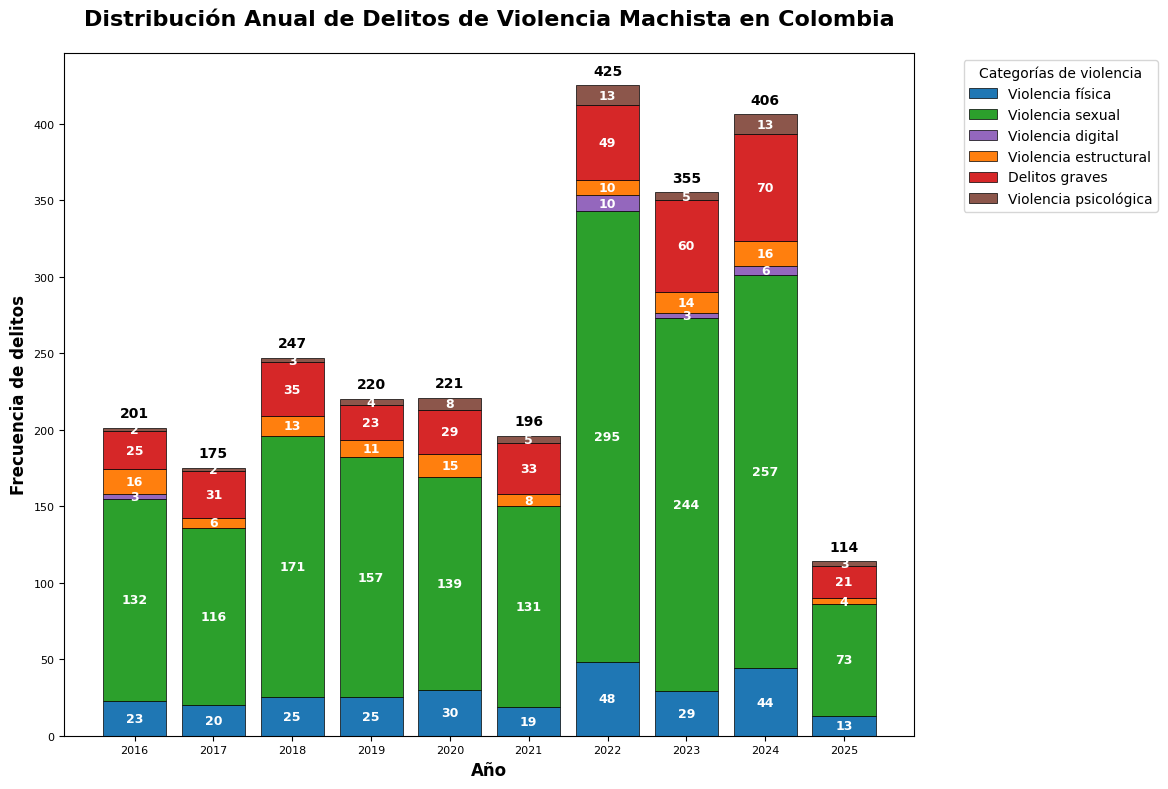

In [56]:
# --- 1. Leer el archivo Excel ---
archivo = '/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal2.xlsx'
try:
    df = pd.read_excel(archivo)
except FileNotFoundError:
    print(f"❌ No se encontró el archivo: {archivo}")
    exit()

# Corregir posible error de codificación en el nombre de la columna
df.columns = [col.replace('paÃ­s', 'pais') if 'paÃ­s' in col else col for col in df.columns]

# Verificar que existe la columna 'país'
if 'pais' not in df.columns:
    print("❌ No se encontró la columna 'país'. Revisa el archivo.")
    print("Columnas disponibles:", df.columns.tolist())
    exit()

# --- 2. Filtrar solo noticias de Colombia ---
df['pais'] = df['pais'].astype(str).str.strip().str.lower()
colombia = df[df['pais'] == 'colombia'].copy()

if len(colombia) == 0:
    print("⚠️ No se encontraron noticias de Colombia. Valores únicos en 'país':")
    print(df['pais'].value_counts())
    exit()

print(f"✅ Filtrado: {len(colombia)} noticias de Colombia")


# --- 8. Categorías temáticas ---
categorias = {
    'Violencia física': ['violencia fisica', 'agresion sexual', 'violencia domestica', 'violencia familiar', 'violencia intrafamiliar'],
    'Violencia sexual': ['abuso sexual', 'violacion', 'violaciones', 'acceso carnal violento', 'acto sexual violento'],
    'Violencia digital': ['ciberviolencia', 'ciberacoso', 'ciberhostigamiento', 'doxing', 'revenge porn'],
    'Violencia estructural': ['discriminacion femenina', 'machismo', 'techo de cristal', 'sexismo', 'cultura de violacion'],
    'Delitos graves': ['feminicidio', 'asesinatos de mujeres', 'trata de mujeres', 'matrimonio forzado', 'esclavitud sexual'],
    'Violencia psicológica': ['violencia psicologica', 'violencia emocional', 'misoginia', 'microagresiones']
}

suma_categorias = {}
for cat, cols in categorias.items():
    existentes = [c for c in cols if c in colombia_violencia.columns]
    suma_categorias[cat] = colombia_violencia[existentes].sum(axis=1).sum()


# --- 13. Diagrama de barras apiladas por AÑO y categorías de delitos ---
if 'fecha' in colombia.columns:
    # Asegurar formato de fecha
    colombia['fecha'] = pd.to_datetime(colombia['fecha'], errors='coerce')
    colombia = colombia.dropna(subset=['fecha'])
    colombia['año'] = colombia['fecha'].dt.year

    # Construir un dataframe de frecuencias por año y categoría
    categorias_df = pd.DataFrame()
    for cat, cols in categorias.items():
        existentes = [c for c in cols if c in colombia_violencia.columns]
        if existentes:
            # Sumar por año cada categoría
            categorias_df[cat] = colombia.groupby('año')[existentes].sum().sum(axis=1)

    # Reemplazar NaN por 0
    categorias_df = categorias_df.fillna(0).astype(int)

    # Ordenar por año
    categorias_df = categorias_df.sort_index()

    # Posiciones en el eje X
    x_pos = np.arange(len(categorias_df))
    years = categorias_df.index.astype(str)

    # Crear gráfico
    fig, ax = plt.subplots(figsize=(14, 8))

    # Definir colores
    colors = ['#1f77b4', '#2ca02c', '#9467bd', '#ff7f0e', '#d62728', '#8c564b']
    colors = colors[:len(categorias_df.columns)]  # En caso de menos categorías

    # Apilar cada categoría
    bottom = np.zeros(len(categorias_df))
    for i, (cat, color) in enumerate(zip(categorias_df.columns, colors)):
        values = categorias_df[cat].values
        ax.bar(x_pos, values, bottom=bottom, color=color, edgecolor='black', linewidth=0.5, label=cat)

        # Añadir valores dentro de cada capa
        for j, (h, val) in enumerate(zip(bottom, values)):
            if val > 0:
                ax.text(j, h + val / 2, str(val), ha='center', va='center',
                        fontsize=9, color='white', fontweight='bold')
        bottom += values

    # Añadir valor total encima de cada barra
    totals = categorias_df.sum(axis=1).values
    for j, total in enumerate(totals):
        ax.text(j, total + 5, str(total), ha='center', va='bottom',
                fontsize=10, color='black', fontweight='bold')

    # Configurar eje X
    ax.set_xticks(x_pos)
    ax.set_xticklabels(years, rotation=0)
    ax.set_xlabel("Año", fontsize=12)
    ax.set_ylabel("Frecuencia de delitos", fontsize=12)
    ax.set_title("Distribución Anual de Delitos de Violencia Machista en Colombia",
                 fontsize=16, fontweight='bold', pad=20)

    # Leyenda
    ax.legend(title="Categorías de violencia", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)

    # Ajustar diseño
    plt.tight_layout(rect=[0, 0, 0.85, 1])
    plt.show()
else:
    print("⚠️ No se encontró la columna 'fecha' en el dataset.")

✅ Filtrado: 1367 noticias de Colombia


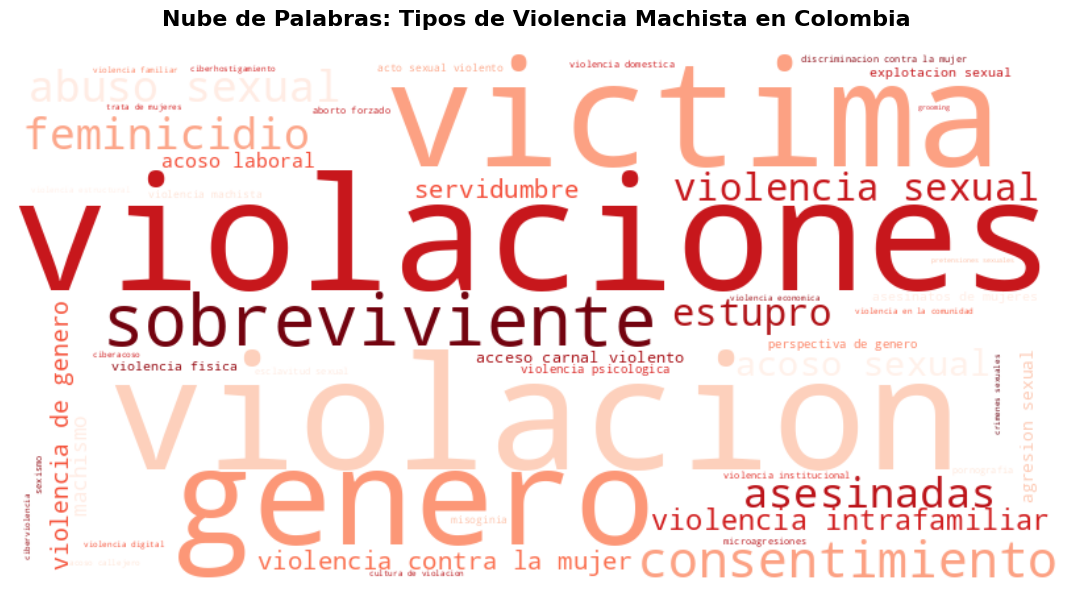

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import numpy as np

# --- 1. Leer el archivo Excel ---
archivo = '/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal2.xlsx'
try:
    df = pd.read_excel(archivo)
except FileNotFoundError:
    print(f"❌ No se encontró el archivo: {archivo}")
    exit()

# Corregir posible error de codificación en el nombre de la columna
df.columns = [col.replace('paÃ­s', 'pais') if 'paÃ­s' in col else col for col in df.columns]

# Verificar que existe la columna 'país'
if 'pais' not in df.columns:
    print("❌ No se encontró la columna 'país'. Revisa el archivo.")
    print("Columnas disponibles:", df.columns.tolist())
    exit()

# --- 2. Filtrar solo noticias de Colombia ---
df['pais'] = df['pais'].astype(str).str.strip().str.lower()
colombia = df[df['pais'] == 'colombia'].copy()

if len(colombia) == 0:
    print("⚠️ No se encontraron noticias de Colombia. Valores únicos en 'país':")
    print(df['pais'].value_counts())
    exit()

print(f"✅ Filtrado: {len(colombia)} noticias de Colombia")

# --- 3. Identificar columnas de violencia (desde la columna H en adelante) ---
start_idx = 7  # Columna H
violence_columns = df.columns[start_idx:].tolist()

colombia_violencia = colombia[violence_columns].copy()
colombia_violencia = colombia_violencia.apply(pd.to_numeric, errors='coerce').fillna(0).astype(int)

# Sumar la frecuencia total de cada delito
frecuencia = colombia_violencia.sum().sort_values(ascending=False)

# --- 5. Nube de palabras ---
word_freq = frecuencia[frecuencia > 0].to_dict()

wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='Reds',
    collocations=False,
    max_words=50,
    contour_color='crimson',
    contour_width=0.5
).generate_from_frequencies(word_freq)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras: Tipos de Violencia Machista en Colombia', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()


## **Distribución mensual de la frecuencia de violencia machista en Colombia**

✅ Filtrado: 1367 noticias de Colombia


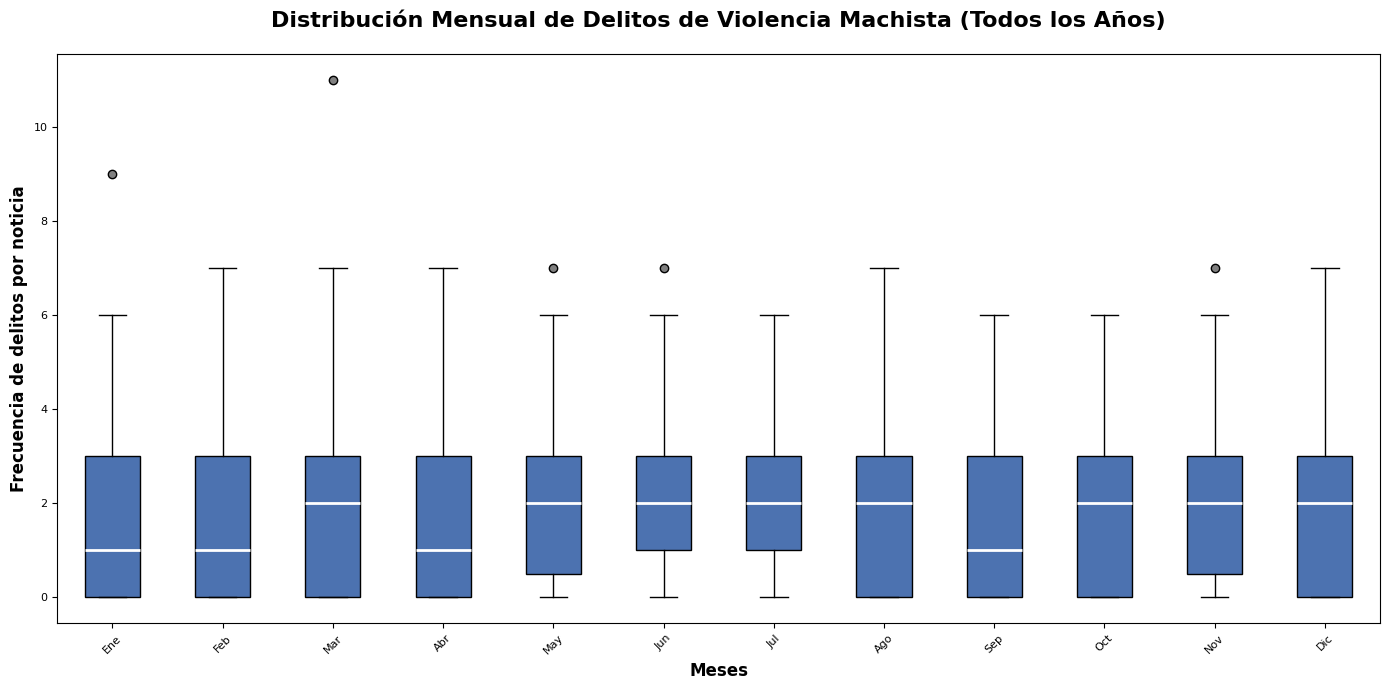

In [42]:
# --- 1. Leer el archivo Excel ---
archivo = '/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal.xlsx'
try:
    df = pd.read_excel(archivo)
except FileNotFoundError:
    print(f"❌ No se encontró el archivo: {archivo}")
    exit()

# Corregir posible error de codificación en el nombre de la columna
df.columns = [col.replace('paÃ­s', 'pais') if 'paÃ­s' in col else col for col in df.columns]

# Verificar que existe la columna 'país'
if 'pais' not in df.columns:
    print("❌ No se encontró la columna 'país'. Revisa el archivo.")
    print("Columnas disponibles:", df.columns.tolist())
    exit()

# --- 2. Filtrar solo noticias de Colombia ---
df['pais'] = df['pais'].astype(str).str.strip().str.lower()
colombia = df[df['pais'] == 'colombia'].copy()

if len(colombia) == 0:
    print("⚠️ No se encontraron noticias de Colombia. Valores únicos en 'país':")
    print(df['pais'].value_counts())
    exit()

print(f"✅ Filtrado: {len(colombia)} noticias de Colombia")


# --- 8. Categorías temáticas ---
categorias = {
    'Violencia física': ['violencia fisica', 'agresion sexual', 'violencia domestica', 'violencia familiar', 'violencia intrafamiliar'],
    'Violencia sexual': ['abuso sexual', 'violacion', 'violaciones', 'acceso carnal violento', 'acto sexual violento'],
    'Violencia digital': ['ciberviolencia', 'ciberacoso', 'ciberhostigamiento', 'doxing', 'revenge porn'],
    'Violencia estructural': ['discriminacion femenina', 'machismo', 'techo de cristal', 'sexismo', 'cultura de violacion'],
    'Delitos graves': ['feminicidio', 'asesinatos de mujeres', 'trata de mujeres', 'matrimonio forzado', 'esclavitud sexual'],
    'Violencia psicológica': ['violencia psicologica', 'violencia emocional', 'misoginia', 'microagresiones']
}

suma_categorias = {}
for cat, cols in categorias.items():
    existentes = [c for c in cols if c in colombia_violencia.columns]
    suma_categorias[cat] = colombia_violencia[existentes].sum(axis=1).sum()

# --- 15. Boxplot: Distribución de delitos por mes (todos los años) ---
if 'fecha' in colombia.columns:
    # Asegurar formato de fecha
    colombia['fecha'] = pd.to_datetime(colombia['fecha'], errors='coerce')
    colombia = colombia.dropna(subset=['fecha'])
    colombia['mes'] = colombia['fecha'].dt.month

    # Calcular el total de violencia por noticia (suma de todas las columnas relevantes)
    categorias_columns = []
    for cols in categorias.values():
        categorias_columns.extend([c for c in cols if c in violence_columns])

    # Eliminar duplicados
    categorias_columns = list(set(categorias_columns))

    if not categorias_columns:
        print("⚠️ No se encontraron columnas de violencia para el boxplot.")
    else:
        # Suma total de violencia por noticia
        colombia['total_violencia'] = colombia[categorias_columns].sum(axis=1)

        # Agrupar por mes y obtener todos los valores (una lista por mes)
        data_by_month = []
        months_names = ['Ene', 'Feb', 'Mar', 'Abr', 'May', 'Jun',
                        'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic']

        for month in range(1, 13):
            values = colombia[colombia['mes'] == month]['total_violencia'].values
            if len(values) == 0:
                values = [0]  # Para que no quede vacío
            data_by_month.append(values)

        # Crear boxplot
        fig, ax = plt.subplots(figsize=(14, 7))

        bp = ax.boxplot(
            data_by_month,
            tick_labels=months_names,  # ✅ cambio aquí
            patch_artist=True,
            boxprops=dict(facecolor='#4C72B0', edgecolor='black'),
            medianprops=dict(color='white', linewidth=2),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(marker='o', markerfacecolor='gray', markersize=6, markeredgecolor='black')

            )

        # Título y etiquetas
        ax.set_title("Distribución Mensual de Delitos de Violencia Machista (Todos los Años)",
                     fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel("Meses", fontsize=12)
        ax.set_ylabel("Frecuencia de delitos por noticia", fontsize=12)
        ax.tick_params(axis='x', rotation=45)

        # Ajustar diseño
        plt.tight_layout()
        plt.show()

else:
    print("⚠️ No se encontró la columna 'fecha' en el dataset.")


# **Distribuciones Georreferenciadas**


## **Mapa de calor de las palabras asociadas a delitos por departamentos**

✅ Archivo cargado exitosamente desde: /content/TFM/datos_corregidos_unificadosmd_normalizadoFinal.xlsx
✅ Departamentos únicos encontrados: 31
✅ Total de delitos reportados en Colombia: 6115
✅ Gráfico guardado exitosamente como: heatmap_delitos_departamentos_valores.png


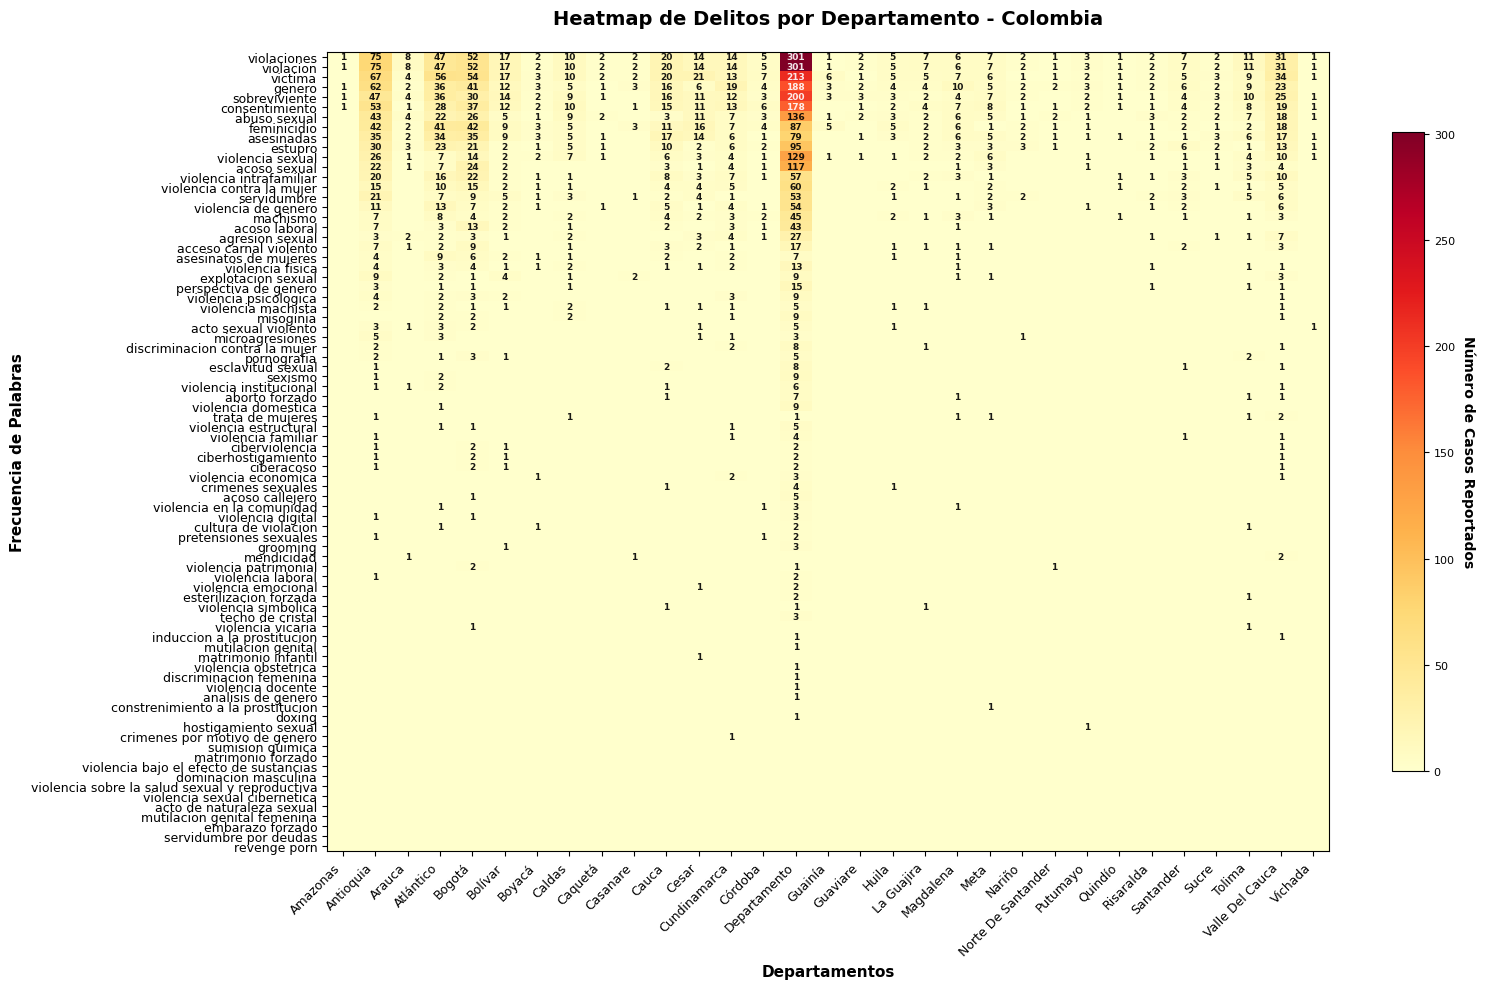

In [44]:
# --- Configuración inicial ---
warnings.filterwarnings('ignore')  # Suprime advertencias no críticas
plt.style.use('default')  # Usa estilo limpio y estándar

# Configuración de fuentes profesionales y compatibles con cualquier sistema
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = [
    'DejaVu Sans',        # Fuente por defecto en matplotlib (siempre disponible)
    'Arial',              # Windows
    'Helvetica',          # macOS
    'Liberation Sans',    # Linux
    'Calibri',
    'Tahoma',
    'Bitstream Vera Sans'
]
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor'] = 'black'
plt.rcParams['axes.titlesize'] = 14

# --- 1. Cargar los datos ---
archivo_path = '/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal.xlsx'
try:
    df = pd.read_excel(archivo_path)
    print(f"✅ Archivo cargado exitosamente desde: {archivo_path}")
except FileNotFoundError:
    raise FileNotFoundError(f"No se encontró el archivo en la ruta: {archivo_path}")
except Exception as e:
    raise Exception(f"Error inesperado al cargar el archivo Excel: {e}")

# --- 2. Filtrar por país Colombia (insensible a mayúsculas y minúsculas) ---
if 'pais' not in df.columns:
    raise KeyError("La columna 'pais' no se encuentra en el archivo Excel.")

df_colombia = df[df['pais'].str.lower() == 'colombia'].copy()

if df_colombia.empty:
    raise ValueError("No se encontraron registros para 'Colombia' en la columna 'pais'.")

# --- 3. Normalizar nombres de departamentos ---
if 'Departamento' not in df_colombia.columns:
    raise KeyError("La columna 'Departamento' no se encuentra en el archivo.")

df_colombia['Departamento'] = df_colombia['Departamento'].astype(str).str.strip().str.title()
df_colombia = df_colombia[df_colombia['Departamento'] != 'Nan']  # Elimina entradas no válidas

# --- 4. Identificar columnas de delitos automáticamente ---
# Suponemos que los delitos comienzan a partir de la columna H (índice 7)
if df_colombia.shape[1] <= 7:
    raise ValueError("El archivo no tiene suficientes columnas. Se esperan al menos 8 columnas (H en adelante para delitos).")

columna_inicio_delitos = df_colombia.columns[7]
delitos = df_colombia.columns[df_colombia.columns.get_loc(columna_inicio_delitos):]

# Convertir columnas de delitos a numéricas, manejando posibles errores
for col in delitos:
    df_colombia[col] = pd.to_numeric(df_colombia[col], errors='coerce').fillna(0)

# --- 5. Contar delitos por departamento ---
try:
    conteo_delitos = df_colombia.groupby('Departamento')[delitos].sum()
    conteo_delitos['total_delitos'] = conteo_delitos.sum(axis=1)
except Exception as e:
    raise Exception(f"Error al agrupar los datos por departamento: {e}")

print(f"✅ Departamentos únicos encontrados: {len(conteo_delitos)}")
print(f"✅ Total de delitos reportados en Colombia: {int(conteo_delitos['total_delitos'].sum())}")

# --- 6. Preparar datos para el heatmap ---
heatmap_data = conteo_delitos.drop('total_delitos', axis=1)

# Ordenar delitos por frecuencia total (de mayor a menor)
heatmap_data = heatmap_data[heatmap_data.sum().sort_values(ascending=False).index]

# Transponer para que los delitos sean filas y los departamentos columnas
data_plot = heatmap_data.T

# --- 7. Crear el heatmap ---
fig, ax = plt.subplots(figsize=(16, 10))

# Mapa de calor con paleta adecuada para representación de magnitud
im = ax.imshow(data_plot, cmap='YlOrRd', aspect='auto', interpolation='nearest')

# Etiquetas en ejes
ax.set_xticks(range(len(heatmap_data)))
ax.set_xticklabels(heatmap_data.index, rotation=45, ha='right', fontsize=9)
ax.set_yticks(range(len(data_plot)))
ax.set_yticklabels(data_plot.index, fontsize=9)

# Título y etiquetas
ax.set_title('Heatmap de Delitos por Departamento - Colombia', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Departamentos', fontweight='bold', fontsize=11)
ax.set_ylabel('Frecuencia de Palabras', fontweight='bold', fontsize=11)

# --- 8. Añadir valores en celdas con contraste adaptativo ---
for i in range(len(data_plot)):          # filas: delitos
    for j in range(len(heatmap_data)):   # columnas: departamentos
        valor = int(data_plot.iloc[i, j])
        if valor > 0:
            # Normalización para decidir el color del texto
            max_val = data_plot.max().max()
            min_val = data_plot.min().min()
            norm_val = (valor - min_val) / (max_val - min_val) if max_val != min_val else 0

            # Texto blanco sobre fondos oscuros, negro sobre fondos claros
            text_color = 'white' if norm_val > 0.5 else 'black'

            ax.text(j, i, str(valor), ha='center', va='center',
                    color=text_color, fontsize=6.5, fontweight='bold', alpha=0.9)

# --- 9. Barra de color ---
cbar = plt.colorbar(im, ax=ax, shrink=0.8)
cbar.set_label('Número de Casos Reportados', rotation=270, labelpad=15, fontsize=10)

# --- 10. Ajustes finales y guardar ---
plt.tight_layout()

# Ruta de salida
output_path = 'heatmap_delitos_departamentos_valores.png'
try:
    plt.savefig(output_path, dpi=300, bbox_inches='tight', facecolor='white')
    print(f"✅ Gráfico guardado exitosamente como: {output_path}")
except Exception as e:
    print(f"⚠️  No se pudo guardar la imagen: {e}")

plt.show()

## **Delitos por departamento**

In [46]:
# 1. Cargar datos desde Excel
archivo_excel = "/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal.xlsx"
df = pd.read_excel(archivo_excel)
df.columns = df.columns.str.strip()
print("Columnas detectadas:", df.columns.tolist())

# 2. Filtrar solo Colombia
df = df[df["pais"].str.lower() == "colombia"]

# 3. Calcular total de delitos (desde columna H en adelante)
col_inicio_delitos = 7  # índice base 0
df["total_delitos"] = df.iloc[:, col_inicio_delitos:].sum(axis=1)

# Agrupar por Departamento
df_mapa = df.groupby("Departamento", as_index=False)["total_delitos"].sum()
print("Totales por departamento:")
print(df_mapa.head())

# 4. Descargar GeoJSON de departamentos
url_geojson = (
    "https://raw.githubusercontent.com/santiblanko/colombia.geojson/master/depto.json"
)
archivo_geojson = "depto_colombia.json"
r = requests.get(url_geojson)
r.raise_for_status()
with open(archivo_geojson, "wb") as f:
    f.write(r.content)
print("GeoJSON de departamentos descargado.")

# 5. Leer el GeoJSON con GeoPandas
gdf = gpd.read_file(archivo_geojson)
print("GeoJSON cargado. Columnas:", gdf.columns.tolist())

# 6. Normalizar nombres: eliminar tildes y uniformar mayúsculas
def normalize(s):
    return unicodedata.normalize("NFKD", str(s)).encode("ASCII", "ignore").decode().upper()

df_mapa["dept_norm"] = df_mapa["Departamento"].apply(normalize)
if "NOMBRE_DPT" in gdf.columns:
    gdf["dept_norm"] = gdf["NOMBRE_DPT"].apply(normalize)
elif "DEPARTAMENT" in gdf.columns:
    gdf["dept_norm"] = gdf["DEPARTAMENT"].apply(normalize)
else:
    gdf["dept_norm"] = gdf.iloc[:, 0].apply(normalize)

# 7. Unir datos
gdf = gdf.merge(df_mapa, on="dept_norm", how="left")
gdf["total_delitos"] = gdf["total_delitos"].fillna(0)

# 8. Crear mapa coroplético
m = folium.Map(location=[4.5709, -74.2973], zoom_start=6)
folium.Choropleth(
    geo_data=gdf,
    data=gdf,
    columns=["dept_norm", "total_delitos"],
    key_on="feature.properties.dept_norm",
    fill_color="YlOrRd",
    fill_opacity=0.7,
    line_opacity=0.3,
    legend_name="Total de delitos reportados"
).add_to(m)

for _, row in gdf.iterrows():
    folium.Marker(
        location=[row.geometry.centroid.y, row.geometry.centroid.x],
        popup=f"{row.get('Departamento', row.get('NOMBRE_DPT', row.get(gdf.columns[0])))}: {int(row['total_delitos'])} delitos",
        icon=folium.Icon(color="red" if row["total_delitos"] > 0 else "gray")
    ).add_to(m)

# 9. Guardar HTML del mapa
ruta_html = "mapa_colombia_delitos.html"
m.save(ruta_html)
print(f"Mapa generado exitosamente: {ruta_html}")

Columnas detectadas: ['ID_noticia', 'fecha', 'diario', 'pais', 'Departamento', 'Municipio', 'enlace', 'abuso sexual', 'pretensiones sexuales', 'acoso sexual', 'acoso callejero', 'agresion sexual', 'ciberviolencia', 'feminicidio', 'grooming', 'explotacion sexual', 'matrimonio forzado', 'mutilacion genital', 'sumision quimica', 'trata de mujeres', 'discriminacion femenina', 'violencia machista', 'machismo', 'violacion', 'violaciones', 'violencia bajo el efecto de sustancias', 'violencia de genero', 'violencia digital', 'violencia domestica', 'violencia familiar', 'violencia intrafamiliar', 'violencia economica', 'violencia vicaria', 'violencia psicologica', 'violencia sexual', 'violencia sobre la salud sexual y reproductiva', 'misoginia', 'asesinatos de mujeres', 'asesinadas', 'dominacion masculina', 'techo de cristal', 'violencia contra la mujer', 'violencia docente', 'violencia en la comunidad', 'violencia fisica', 'violencia institucional', 'violencia laboral', 'violencia patrimonial'

## **Delitos por municipio**

In [49]:
# 1. Cargar datos desde Excel
archivo_excel = "/content/TFM/datos_corregidos_unificadosmd_normalizadoFinal.xlsx"
df = pd.read_excel(archivo_excel)
df.columns = df.columns.str.strip()
print("Columnas detectadas:", df.columns.tolist())

# 2. Filtrar solo Colombia
df = df[df["pais"].str.lower() == "colombia"]

# 3. Calcular total de delitos (desde columna H en adelante, índice base 0: columna 7)
col_inicio_delitos = 7
df["total_delitos"] = df.iloc[:, col_inicio_delitos:].sum(axis=1)

# 4. Agrupar por MUNICIPIO (columna F, que es la columna índice 5)
df_municipios = df.groupby("Municipio", as_index=False)["total_delitos"].sum()
print("Totales por municipio:")
print(df_municipios.head())

# 5. Normalizar nombres de municipios para geocodificación
def normalize(s):
    return unicodedata.normalize("NFKD", str(s)).encode("ASCII", "ignore").decode().upper()

df_municipios["municipio_norm"] = df_municipios["Municipio"].apply(normalize)

# 6. Geocodificar municipios (obtener latitud y longitud)
geolocator = Nominatim(user_agent="colombia_delitos_map")

def geocodificar_municipio(nombre):
    try:
        # Buscar como "Municipio, Colombia"
        location = geolocator.geocode(f"{nombre}, Colombia", timeout=10)
        if location:
            return pd.Series([location.latitude, location.longitude])
        else:
            print(f"⚠️ No se encontró: {nombre}")
            return pd.Series([None, None])
    except (GeocoderTimedOut, GeocoderServiceError) as e:
        print(f"❌ Error con {nombre}: {e}")
        return pd.Series([None, None])

# Aplicar geocodificación con pausas para no saturar la API
print("Iniciando geocodificación de municipios...")
coords = df_municipios["Municipio"].apply(geocodificar_municipio)
df_municipios["lat"] = coords[0]
df_municipios["lon"] = coords[1]

# Filtrar municipios sin coordenadas
df_municipios = df_municipios.dropna(subset=["lat", "lon"]).reset_index(drop=True)
print(f"✅ {len(df_municipios)} municipios geocodificados con éxito.")

# 7. Crear mapa centrado en Colombia
m = folium.Map(location=[4.5709, -74.2973], zoom_start=6, tiles="OpenStreetMap")

# 8. Añadir marcadores para cada municipio
for _, row in df_municipios.iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=max(3, row["total_delitos"] / 50),  # Tamaño proporcional a delitos
        color="red",
        fill=True,
        fill_color="red",
        fill_opacity=0.6,
        popup=f"<b>{row['Municipio']}</b><br>Total delitos: {int(row['total_delitos'])}",
        tooltip=row["Municipio"]
    ).add_to(m)

# 9. Guardar el mapa
ruta_html = "mapa_colombia_municipios_delitos.html"
m.save(ruta_html)
print(f"✅ Mapa generado exitosamente: {ruta_html}")

Columnas detectadas: ['ID_noticia', 'fecha', 'diario', 'pais', 'Departamento', 'Municipio', 'enlace', 'abuso sexual', 'pretensiones sexuales', 'acoso sexual', 'acoso callejero', 'agresion sexual', 'ciberviolencia', 'feminicidio', 'grooming', 'explotacion sexual', 'matrimonio forzado', 'mutilacion genital', 'sumision quimica', 'trata de mujeres', 'discriminacion femenina', 'violencia machista', 'machismo', 'violacion', 'violaciones', 'violencia bajo el efecto de sustancias', 'violencia de genero', 'violencia digital', 'violencia domestica', 'violencia familiar', 'violencia intrafamiliar', 'violencia economica', 'violencia vicaria', 'violencia psicologica', 'violencia sexual', 'violencia sobre la salud sexual y reproductiva', 'misoginia', 'asesinatos de mujeres', 'asesinadas', 'dominacion masculina', 'techo de cristal', 'violencia contra la mujer', 'violencia docente', 'violencia en la comunidad', 'violencia fisica', 'violencia institucional', 'violencia laboral', 'violencia patrimonial'